# init

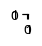

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# init

## reloading datasets

In [9]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [10]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [11]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [12]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [13]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# Redef data processing fct

In [34]:
cedar_aligned['len_core_mut'] = cedar_aligned['core_mut'].apply(len)
cedar_aligned.len_core_mut.unique()

array([9])

In [35]:
cedar_aligned['CoreNotAA'] = cedar_aligned['core_mut'].apply(lambda x: any([z not in AA_KEYS for z in x]))
cedar_aligned['n-'] = cedar_aligned['core_mut'].apply(lambda x: x.count('-'))
cedar_aligned['core_eq'] = cedar_aligned['core_wt_aligned']==cedar_aligned['core_mut']
cedar_aligned['icore_eq'] = cedar_aligned['icore_wt_aligned']==cedar_aligned['icore_mut']

In [49]:
cedar_aligned.groupby(['icore_eq', 'core_eq','CoreNotAA', 'len_icore_mut']).count()

HLA  agg_label  fold  Peptide  \
icore_eq core_eq CoreNotAA len_icore_mut                                   
False    False   False     9              2067       2067  2067     2067   
                           10              485        485   485      485   
                           11              207        207   207      207   
                           12                1          1     1        1   
                 True      8                99         99    99       99   
         True    False     10               29         29    29       29   
                           11               29         29    29       29   
True     True    False     9                79         79    79       79   
                           10               11         11    11       11   
                 True      8                26         26    26       26   

                                          wild_type  icore_mut  core_mut  \
icore_eq core_eq CoreNotAA len_icore_mut                                   
False    False   False     9                   2067       2067      2067   
                           10                   485        485       485   
                           11                   207        207       207   
                           12                     1          1         1   
                 True      8                     99         99        99   
         True    False     10                    29         29        29   
                           11                    29         29        29   
True     True    False     9                     79         79        79   
                           10                    11         11        11   
                 True      8                     26         26        26   

                                           len  EL_rank_mut  EL_rank_wt  ...  \
icore_eq core_eq CoreNotAA len_icore_mut                                 ...   
False    False   False     9              2067         2067        2067  ...   
                           10              485          485         485  ...   
                           11              207          207         207  ...   
                           12                1            1           1  ...   
                 True      8                99           99          99  ...   
         True    False     10               29           29          29  ...   
                           11               29           29          29  ...   
True     True    False     9                79           79          79  ...   
                           10               11           11          11  ...   
                 True      8                26           26          26  ...   

                                          isoelectric_point  VHSE1  VHSE3  \
icore_eq core_eq CoreNotAA len_icore_mut                                    
False    False   False     9                           2067   2067   2067   
                           10                           485    485    485   
                           11                           207    207    207   
                           12                             1      1      1   
                 True      8                             99     99     99   
         True    False     10                            29     29     29   
                           11                            29     29     29   
True     True    False     9                             79     79     79   
                           10                            11     11     11   
                 True      8                             26     26     26   

                                          VHSE7  VHSE8  seq_id  \
icore_eq core_eq CoreNotAA len_icore_mut                         
False    False   False     9               2067   2067    2067   
                           10               485    485     485   
                           11               207    207     207   
 

In [52]:
cedar_aligned.query('len_icore_mut>len_core_mut')[['HLA','agg_label','Peptide','icore_mut', 'core_mut', 
                                                   'wild_type','icore_wt_aligned','core_wt_aligned','icore_eq','core_eq']]

,HLA,agg_label,Peptide,icore_mut,core_mut,wild_type,icore_wt_aligned,core_wt_aligned,icore_eq,core_eq
5,HLA-B0702,0,AALHTPRPGPL,ALHTPRPGPL,ALHTPRPPL,AALHNPRPGPL,ALHNPRPGPL,ALHNPRPPL,False,False
13,HLA-A1101,0,AAYQRLTSEK,AAYQRLTSEK,AAYQLTSEK,AAYQQLTSEK,AAYQQLTSEK,AAYQQLTSK,False,False
20,HLA-B4403,0,AEVDQDGVVM,AEVDQDGVVM,AEVDQGVVM,AEVDEDGVVM,AEVDEDGVVM,AEVDEGVVM,False,False
22,HLA-A6801,0,AEWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,PEWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,True,True
23,HLA-A2402,0,AFLSTHLKLFL,AFLSTHLKLF,AFLSTHLLF,AFLSTHLKLFP,AFLSTHLKLF,AFLSTHLLF,True,True
...,...,...,...,...,...,...,...,...,...,...
3009,HLA-A0201,0,YVARGGSMGV,YVARGGSMGV,YVAGGSMGV,YVARGGPMGV,YVARGGPMGV,YVAGGPMGV,False,False
3010,HLA-A0201,0,YVEYYSWLSYL,YVEYYSWLSYL,YVYSWLSYL,YVEYYRWLSYL,YVEYYRWLSYL,YVYRWLSYL,False,False
3016,HLA-B0702,0,YVRRVFITDDL,YVRRVFITDDL,YVRRVFITL,YVRRVFITDDF,YVRRVFITDDF,YVRRVFITF,False,False
3018,HLA-A6801,0,YVSEKDVISAK,YVSEKDVISAK,YVSDVISAK,YVSEKDVTSAK,YVSEKDVTSAK,YVSDVTSAK,False,False


In [47]:
cedar_aligned.query('CoreNotAA')[['HLA','agg_label','Peptide','wild_type','icore_mut','icore_wt_aligned','icore_eq','core_mut','core_wt_aligned','core_eq']]

,HLA,agg_label,Peptide,wild_type,icore_mut,icore_wt_aligned,icore_eq,core_mut,core_wt_aligned,core_eq
39,HLA-A0201,0,AIYHTLNLFNI,AIYHTLNLCNI,AIYHTLNL,AIYHTLNL,True,AIY-HTLNL,AIY-HTLNL,True
40,HLA-B0702,0,AKNCGIAIPV,AKNRGIAIPV,AKNCGIAI,AKNRGIAI,False,-AKNCGIAI,-AKNRGIAI,False
105,HLA-B1501,0,ALSIGTSYRY,ALSIGTPYRY,ALSIGTSY,ALSIGTPY,False,ALS-IGTSY,ALS-IGTPY,False
133,HLA-A0201,0,AMYLNYFRGL,AMYLNYCRGL,YLNYFRGL,YLNYCRGL,False,YLN-YFRGL,YL-NYCRGL,False
158,HLA-B0702,0,APTWRALAR,APTWRALAG,APTWRALA,APTWRALA,True,APT-WRALA,APT-WRALA,True
...,...,...,...,...,...,...,...,...,...,...
2838,HLA-C1403,0,WYTHNLIFVF,WYTHNLFFVF,WYTHNLIF,WYTHNLFF,False,WYT-HNLIF,WYT-HNLFF,False
2869,HLA-A0201,1,YKLVVVGAV,YKLVVVGAG,KLVVVGAV,KLVVVGAG,False,KLV-VVGAV,KLVVVGAG-,False
2933,HLA-A1101,1,YMKSLEFENK,YMKSSEFENK,KSLEFENK,KSSEFENK,False,KSLE-FENK,KSSE-FENK,False
3013,HLA-A0201,0,YVMASVFVCPL,YVMASVFVCLL,YVMASVFV,YVMASVFV,True,YVMASVF-V,YVMASVF-V,True


In [ ]:
def get_core_dataset(df, ics_dict, max_len=9, encoding='onehot', blosum_matrix=BL62_VALUES,
                     seq_col='core_mut', hla_col='HLA', target_col='agg_label', rank_col='EL_rank_mut',
                     mut_col=None, mask=False, invert=False, add_rank=False, mask_aa=None):
    """
    """
    x, y = get_array_dataset(df, ics_dict, max_len, encoding, blosum_matrix, seq_col, hla_col, target_col, rank_col,
                             mask, invert, add_rank=add_rank, add_aaprop=add_aaprop, remove_pep=remove_pep)
    
    
    if mut_col is not None and type(mut_col) == list:
        if len(mut_col) > 0:
            mut_scores = df[mut_col].values
            x = np.concatenate([x, mut_scores], axis=1)
    if mask_aa:
        if mask_aa.lower() == 'false':
            return x, y
        assert mask_aa.upper() in AA_KEYS, f'Amino acid to mask is not in the AA alphabet!' \
                                           '\nYou provided {mask_aa}, and the alphabet is {AA_KEYS}'
        x[:, AA_KEYS.index(mask_aa.upper())] = 0
    return x, y

In [84]:
# Replacing the '-' with zeros so that we ignore that position but keep the ordering (needed for the IC weights to be on the right pos)
CHAR_TO_INT['-']=-1
INT_TO_CHAR[-1]='-'
seq='AIY-HTLNL'
int_encoded = [CHAR_TO_INT[x] for x in seq]
onehot_encoded = list()
for value in int_encoded:
    letter = [0 for _ in range(len(AA_KEYS))]
    letter[value] = 1 if value != -1 else 0
    onehot_encoded.append(letter)
tmp = np.array(onehot_encoded)
tmp[3,:]==0, tmp.shape == (9,20) # check that the position 3 is all 0 and array has the right shape

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 True)

In [314]:
import torch
def find_extra_aa(core, icore):
    assert len(core)==9, f'Core is not of length 9 somehow: {core}'
    if len(icore)==len(core) or len(icore)==8:
        return np.zeros((20))
    
    elif len(icore)>len(core):
        results = []
        j = 0
        for i, char in enumerate(icore):
            if char!=core[j]:
                results.append(char)
            else:
                j+=1
        return (encode(''.join(results)).sum(axis=0).numpy() / len(icore)).astype(np.float32)
    
def batch_find_extra_aa(core_seqs, icore_seqs):
    return np.stack(map(find_aa, core_seqs,icore_seqs)).astype(np.float32)

In [302]:
from src.data_processing import batch_compute_frequency, encode_batch_weighted, encode_batch, get_ic_weights, CHAR_TO_INT, INT_TO_CHAR, encode, get_ic_weights
# All 3 cases, where core with a '-', Icore > core, Icore==core
sample = pd.concat([cedar_aligned.query('CoreNotAA').sample(2, random_state=13), 
                    cedar_aligned.query('len_icore_mut>len_core_mut').sample(2, random_state=13),
                    cedar_aligned.query('len_icore_mut==len_core_mut').sample(2, random_state=13)])
core_seqs = sample['core_mut'].values
icore_seqs = sample['icore_mut'].values
core_seqs, icore_seqs, len(sample)

(array(['SVS-FGTVY', 'SYWNR-LQF', 'FLQEVNVGV', 'KMFKTTPPV', 'QLDIIPASV',
        'ITDAHELGV'], dtype=object),
 array(['SVSFGTVY', 'SYWNRLQF', 'FLQEVNVCGV', 'KMTNFKTTPPV', 'QLDIIPASV',
        'ITDAHELGV'], dtype=object),
 6)

In [306]:
encode_batch_weighted(sample, ics_shannon, None, 9, 'onehot', None, 'core_mut')

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9169,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.3213],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9634,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [315]:
weighted_sequences = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut')
# Here added a special argument "true_lens" where we provide the true lengths
freqs = batch_compute_frequency(weighted_sequences.numpy(), true_lens=9)
extra_freqs = batch_find_extra_aa(core_seqs, icore_seqs)
summed = np.add(freqs,extra_freqs)
summed[4:]

before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


array([[0.10369743, 0.        , 0.        , 0.10237203, 0.        ,
        0.09803756, 0.        , 0.        , 0.        , 0.19956324,
        0.0370485 , 0.        , 0.        , 0.        , 0.09752864,
        0.10269237, 0.        , 0.        , 0.        , 0.04814585],
       [0.10457226, 0.        , 0.        , 0.08788767, 0.        ,
        0.        , 0.10608057, 0.10462533, 0.10660405, 0.10613236,
        0.10538305, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07088175, 0.        , 0.        , 0.01572936]],
      dtype=float32)

In [325]:
x,y = get_dataset(sample, ics_shannon, max_len=9, encoding='onehot', blosum_matrix=None, seq_col='core_mut', hla_col='HLA', target_col='agg_label',
                  rank_col='EL_rank_mut', mask=False, invert=False, add_rank=True, add_aaprop=False, remove_pep=False, icore_bulge=True,
                  core_col='core_mut', icore_col='icore_mut')

True
here
before 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
after drop 6 Int64Index([785, 1276, 527, 1216, 1852, 1044], dtype='int64')
xd!! 6


# Training a model with only rank and all weightings

In [341]:

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')
encoding_kwargs.pop('standardize')
x,y=get_dataset(sample, ics_shannon, **encoding_kwargs)
(x[:,:20]==summed).all()

True

In [419]:
sample

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,len_core_mut,CoreNotAA,n-,core_eq,icore_eq,icore_eq_core
785,HLA-C1403,0,7,GSVSFGTVY,GSGSFGTVY,SVSFGTVY,SVS-FGTVY,9,2.4606,3.7812,...,-0.188750,>seq_786,SGS-FGTVY,3.7812,9,True,1,False,False,False
1276,HLA-A2402,0,5,KSYWNRLQF,KSYWNRLRF,SYWNRLQF,SYWNR-LQF,9,0.2599,0.3379,...,-0.307500,>seq_1277,SYW-NRLRF,0.3379,9,True,1,False,False,False
527,HLA-A0203,1,8,FLQEVNVCGV,FLQEVNVYGV,FLQEVNVCGV,FLQEVNVGV,10,0.3130,0.2390,...,-0.363000,>seq_528,FLQEVNVYV,0.2390,9,False,0,False,False,False
1216,HLA-A0201,0,3,KMTNFKTTPPV,KMTDFKTTPPV,KMTNFKTTPPV,KMFKTTPPV,11,1.9568,0.9945,...,0.621818,>seq_1217,KMTDFTPPV,0.9945,9,False,0,False,False,False
1852,HLA-A0201,1,9,QLDIIPASV,QLDIIPASI,QLDIIPASV,QLDIIPASV,9,0.1110,0.4652,...,0.270000,>seq_1853,QLDIIPASI,0.4652,9,False,0,False,False,True
1044,HLA-A0101,0,8,ITDAHELGVA,ITAAHELGVA,ITDAHELGV,ITDAHELGV,10,0.3941,5.1050,...,-0.108889,>seq_1045,ITAAHELGV,5.1050,9,False,0,False,False,True


In [423]:
a,b = encode_batch_weighted(sample, ics_dict=ics_shannon, max_len=9, seq_col='core_mut')
a.shape, b.shape

(torch.Size([6, 9, 20]), (6, 9))

In [427]:
def x(a,b):
    return a+b
def f(a):
    return a, 2*a

x(*f(2))

6

In [389]:
from src.utils import mkdirs
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
outdir = '../output/230314_bulgeOut_aligned/'
mkdirs(outdir)
mkdirs(f'{outdir}raw/')
mkdirs(f'{outdir}bootstrapping/')

train_dataset = cedar_aligned
cedar_dataset = cedar_aligned
prime_dataset = prime_aligned
nepdb_dataset = nepdb_aligned


def final_bootstrap_wrapper(preds_df, filename, ic_name, icore_bulge, key, evalset,
                            n_rounds=10000, n_jobs=36):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['bulgeOut'] = icore_bulge
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'core_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut', rank_col='EL_rank_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')

mega_df = pd.DataFrame()

print(encoding_kwargs['icore_bulge'])
for invert in [True, False]:
    for ic_name, ics_dict in tqdm(
            zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
            desc='Weighting', leave=False, position=2):
        # Set args
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
        # Load params
        if invert:
            if ic_name == 'None':
                continue
            else:
                ic_name = 'Inverted ' + ic_name

        filename = f'onehot_{"-".join(ic_name.split(" "))}_bulgeOut{encoding_kwargs["icore_bulge"]}_rank_only'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training', encoding_kwargs)
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank']
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(f'{outdir}raw/featimps_{filename}.csv', index=False)

        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=False)
            # p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(
                f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False)

            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, encoding_kwargs['icore_bulge'],
                                                      'only_rank', evalname, n_rounds=10000,
                                                      n_jobs=8)
            mega_df = mega_df.append(bootstrapped_df)
mega_df.to_csv(f'{outdir}/total_df.csv', index=False)


True


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/CEDAR_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/PRIME_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230314_bulgeOut_aligned/bootstrapping/NEPDB_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


In [477]:
def find_extra_aa(core, icore):
    """
    Finds the bulging out AA between an icore and its corresponding core, returning the extra AA as "frequencies"
    Args:
        core:
        icore:

    Returns:

    """
    assert len(core) == 9, f'Core is not of length 9 somehow: {core}'
    if len(icore) == len(core) or len(icore) == 8:
        return np.zeros((20))

    elif len(icore) > len(core):
        results = []
        j = 0
        for i, char in enumerate(icore):
            if char != core[j]:
                results.append(char)
            else:
                j += 1
        # Here changed to len icore - len core to get len of bulge
        # return (encode(''.join(results)).sum(axis=0).numpy() / (len(icore)-len(core))).astype(np.float32)

        # Here, changed to return the extra + the length so that we can do the weighted division
        return encode(''.join(results)).sum(axis=0).numpy(), np.array(len(icore)-len(core))

def batch_find_extra_aa(core_seqs, icore_seqs):
    """
    Same as above but by batch
    Args:
        core_seqs:
        icore_seqs:

    Returns:

    """
    mapped = list(map(find_extra_aa, core_seqs, icore_seqs))
    encoded, lens = np.array([x[0] for x in mapped]), np.array([x[1] for x in mapped])
    return encoded, lens
x,w = encode_batch_weighted(sample, ics_shannon, 'cpu', 9, seq_col='core_mut', return_weights=True)
extra_freqs, extra_lens = batch_find_extra_aa(sample['core_mut'].values, sample['icore_mut'].values)

In [ ]:
extra_lens

array([0., 0., 1., 2., 0., 0.])

In [ ]:
x.sum(axis=1)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9563, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.9604, 0.0000, 1.8803, 0.9475, 0.0000,
         0.4945, 1.2588],
        [0.0000, 0.9615, 0.9423, 0.0000, 0.0000, 0.9364, 0.0000, 0.0000, 0.0000,
         0.0000, 0.9621, 0.0000, 0.0000, 0.4905, 0.0000, 0.9403, 0.0000, 0.9483,
         0.3512, 0.0000],
        [0.0000, 0.0000, 0.8612, 0.0000, 0.0000, 0.9371, 0.8460, 0.9149, 0.0000,
         0.0000, 0.3467, 0.0000, 0.0000, 0.8795, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 2.3462],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.7204, 0.3334, 0.9213, 1.8575, 0.0000, 1.8357, 0.0000,
         0.0000, 0.4333],
        [0.9333, 0.0000, 0.0000, 0.9213, 0.0000, 0.8823, 0.0000, 0.0000, 0.0000,
         1.7961, 0.3334, 0.0000, 0.0000, 0.0000, 0.8778, 0.9242, 0.0000, 0.0000,
         0.0000, 0.4333],
        [0.9412, 0.0000, 0.0000, 0.7910, 0.0000, 0.0000, 0.9

In [519]:
weights = w.mean(axis=2).sum(axis=1) + extra_lens

In [ ]:
batch_compute_frequency(x, np.repeat(weights0))

RuntimeError: The size of tensor a (6) must match the size of tensor b (2) at non-singleton dimension 0

In [553]:
from src.utils import mkdirs
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

# Rerun but here in the code I changed the find_extra_aa to divide by the length of the 
# bulge rather than by the length of the entire icore
outdir = '../output/230320_bulgeOut_aligned_divideByWeights/'
mkdirs(outdir)
mkdirs(f'{outdir}raw/')
mkdirs(f'{outdir}bootstrapping/')

train_dataset = cedar_aligned
cedar_dataset = cedar_aligned
prime_dataset = prime_aligned
nepdb_dataset = nepdb_aligned


def final_bootstrap_wrapper(preds_df, filename, ic_name, icore_bulge, key, evalset,
                            n_rounds=10000, n_jobs=36):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['bulgeOut'] = icore_bulge
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'core_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

encoding_kwargs = dict(max_len=9, encoding='onehot', blosum_matrix=None, mask=False, add_rank=True,
                       add_aaprop=False, remove_pep=False, standardize=True, seq_col='core_mut', rank_col='EL_rank_mut',
                       icore_bulge=True, core_col='core_mut', icore_col='icore_mut')

mega_df = pd.DataFrame()

print(encoding_kwargs['icore_bulge'])
for invert in [True, False]:
    for ic_name, ics_dict in tqdm(
            zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
            desc='Weighting', leave=False, position=2):
        # Set args
        encoding_kwargs['invert'] = invert
        encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
        # Load params
        if invert:
            if ic_name == 'None':
                continue
            else:
                ic_name = 'Inverted ' + ic_name

        filename = f'onehot_{"-".join(ic_name.split(" "))}_bulgeOut{encoding_kwargs["icore_bulge"]}_rank_only'
        # Using the same model and hyperparameters
        model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                       max_depth=8, ccp_alpha=9.945e-6)
        # Training model and getting feature importances
        print('Training', encoding_kwargs)
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                    ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs,
                                                                    n_jobs=8)
        fi = get_nested_feature_importance(trained_models)
        fn = AA_KEYS + ['rank']
        df_fi = pd.DataFrame(fi, index=fn).T
        df_fi.to_csv(f'{outdir}raw/featimps_{filename}.csv', index=False)

        for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                                     ['CEDAR', 'PRIME', 'NEPDB']):
            # FULLY FILTERED + Mean_pred
            if not evalset.equals(train_dataset):
                evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
            _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                       trained_models, ics_dict,
                                                       train_dataset,
                                                       encoding_kwargs, concatenated=False,
                                                       only_concat=False)
            # p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
            preds.to_csv(
                f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False)

            bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name, encoding_kwargs['icore_bulge'],
                                                      'only_rank', evalname, n_rounds=10000,
                                                      n_jobs=8)
            mega_df = mega_df.append(bootstrapped_df)
mega_df.to_csv(f'{outdir}/total_df.csv', index=False)


True


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': True}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.pkl saved.


Weighting: 0it [00:00, ?it/s]

Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': True, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Mask_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_KL_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_None_bulgeOutTrue_rank_only.pkl saved.
Training {'max_len': 9, 'encoding': 'onehot', 'blosum_matrix': None, 'mask': False, 'add_rank': True, 'add_aaprop': False, 'remove_pep': False, 'standardize': True, 'seq_col': 'core_mut', 'rank_col': 'EL_rank_mut', 'icore_bulge': True, 'core_col': 'core_mut', 'icore_col': 'icore_mut', 'invert': False}


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/CEDAR_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/PRIME_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230320_bulgeOut_aligned_divideByWeights/bootstrapping/NEPDB_mean_rocs_onehot_Shannon_bulgeOutTrue_rank_only.pkl saved.


# Results

Should compare the results between core+bulge out, vs ICORE (like normal aligned from before using only rank)

see 230125_aligned_icore_mutscore + query for "only rank"

In [392]:
mega_icore_df = pd.read_csv('../output/230125_aligned_icore_mutscore/total_df.csv').query('key=="only_rank" and encoding=="onehot"')

In [554]:
total_df_old_div = pd.read_csv('../output/230314_bulgeOut_aligned/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_old_div['AA_bulge'] = 'old_div'

total_df_new_div = pd.read_csv('../output/230314_bulgeOut_aligned_diffDivision/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_new_div['AA_bulge'] = 'new_div'

total_df_divweight = pd.read_csv('../output/230320_bulgeOut_aligned_dividebyweights/total_df.csv').rename(columns={'bulgeOut':'AA_bulge'})
total_df_divweight['AA_bulge'] = 'div_by_summedWeight'

In [555]:
mega_icore_df = mega_icore_df.query('evalset!="IBEL"')
mega_icore_df['AA_bulge']= 'None'

In [556]:
concat=pd.concat([mega_icore_df, total_df_old_div, total_df_new_div, total_df_divweight])
gb_list = []
for evalset in concat.evalset.unique():
    tmp = concat.query('evalset==@evalset')
    tmp = tmp.groupby(['weight', 'pep_col', 'AA_bulge']).agg(mean_auc=('auc','mean'), mean_auc01=('auc_01', 'mean'), mean_AP=('AP', 'mean'))
    tmp.columns = [f'{x}_{evalset}' for x in tmp.columns]
    gb_list.append(tmp)
gb_merged = pd.concat(gb_list, axis=1)

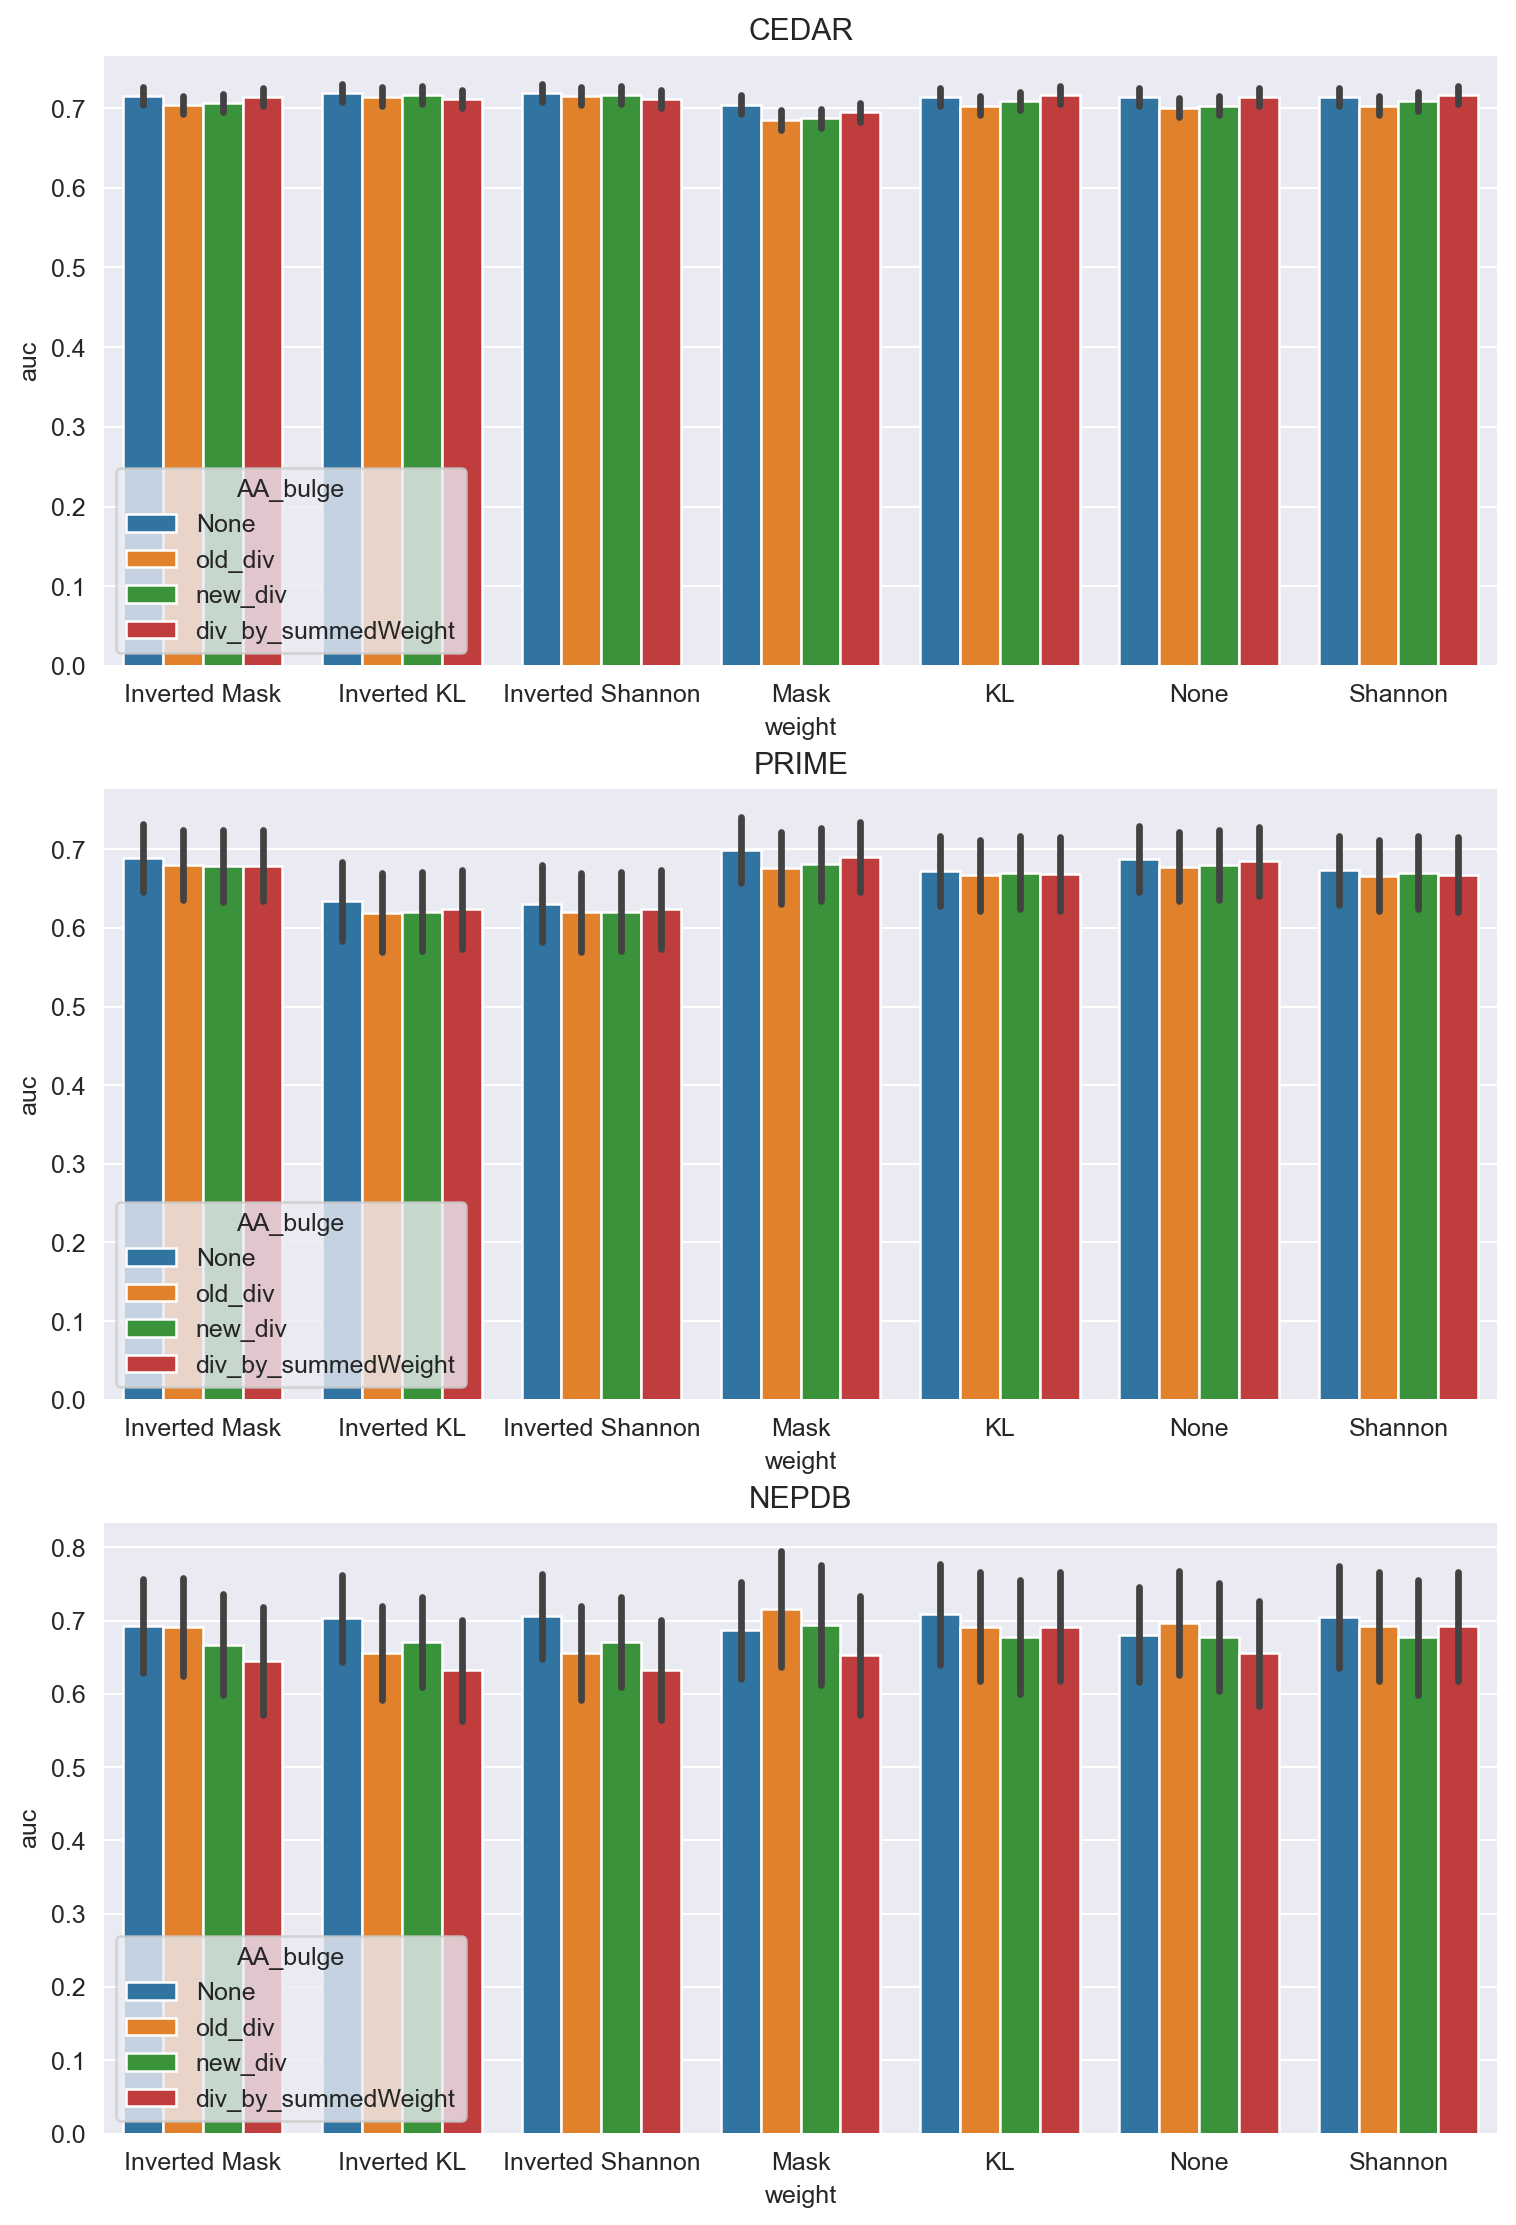

In [564]:
f,a = plt.subplots(3,1,figsize=(10,15))
for i, evalset in enumerate(concat.evalset.unique()):
    sns.barplot(data=concat.query('evalset==@evalset'), x='weight', y='auc', hue='AA_bulge', ax=a[i], errorbar='sd')
    a[i].set_title(evalset)

In [403]:
sample

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,len_core_mut,CoreNotAA,n-,core_eq,icore_eq,icore_eq_core
785,HLA-C1403,0,7,GSVSFGTVY,GSGSFGTVY,SVSFGTVY,SVS-FGTVY,9,2.4606,3.7812,...,-0.188750,>seq_786,SGS-FGTVY,3.7812,9,True,1,False,False,False
1276,HLA-A2402,0,5,KSYWNRLQF,KSYWNRLRF,SYWNRLQF,SYWNR-LQF,9,0.2599,0.3379,...,-0.307500,>seq_1277,SYW-NRLRF,0.3379,9,True,1,False,False,False
527,HLA-A0203,1,8,FLQEVNVCGV,FLQEVNVYGV,FLQEVNVCGV,FLQEVNVGV,10,0.3130,0.2390,...,-0.363000,>seq_528,FLQEVNVYV,0.2390,9,False,0,False,False,False
1216,HLA-A0201,0,3,KMTNFKTTPPV,KMTDFKTTPPV,KMTNFKTTPPV,KMFKTTPPV,11,1.9568,0.9945,...,0.621818,>seq_1217,KMTDFTPPV,0.9945,9,False,0,False,False,False
1852,HLA-A0201,1,9,QLDIIPASV,QLDIIPASI,QLDIIPASV,QLDIIPASV,9,0.1110,0.4652,...,0.270000,>seq_1853,QLDIIPASI,0.4652,9,False,0,False,False,True
1044,HLA-A0101,0,8,ITDAHELGVA,ITAAHELGVA,ITDAHELGV,ITDAHELGV,10,0.3941,5.1050,...,-0.108889,>seq_1045,ITAAHELGV,5.1050,9,False,0,False,False,True


# 230417 RE-RE-REdefine icore/pep input stuff

## redef mixed inputs

In [14]:
def improved_binder(rank_mut, rank_wt):
    if rank_mut / rank_wt >= 1:
        return False
    else:
        if rank_mut>2.0:
            return False
        else:
            if rank_wt/rank_mut >= 2:
                return True
            else:
                return False
cedar_aligned_expr['impr_icore'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['EL_rank_mut'],x['EL_rank_wt_aligned']), axis=1)
cedar_aligned_expr['impr_pep'] = cedar_aligned_expr.apply(lambda x: improved_binder(x['trueHLA_EL_rank'],x['EL_rank_wt']), axis=1)

In [15]:
len(cedar_aligned_expr.query('impr_icore')), len(cedar_aligned_expr.query('impr_icore and not impr_pep')), len(cedar_aligned_expr.query('not impr_icore and impr_pep')), len(cedar_aligned_expr.query('impr_pep'))

(962, 202, 0, 760)

In [16]:
cedar_aligned_expr.query('impr_icore and not impr_pep')[['Peptide','wild_type', 'icore_mut', 'icore_wt_aligned', 'trueHLA_EL_rank', 'EL_rank_mut', 'EL_rank_wt', 'EL_rank_wt_aligned']]

,Peptide,wild_type,icore_mut,icore_wt_aligned,trueHLA_EL_rank,EL_rank_mut,EL_rank_wt,EL_rank_wt_aligned
33,AILPFTPEFL,AISPFTPEFL,ILPFTPEFL,ISPFTPEFL,0.7790,0.5632,1.4141,9.3854
34,AILPFTPEFLV,AISPFTPEFLV,ILPFTPEFL,ISPFTPEFL,0.6360,0.5632,1.0875,9.3854
53,ALAQKGVQLGL,ALARKGVQLGL,ALAQKGVQL,ALARKGVQL,1.0357,0.2014,0.4706,0.4706
72,ALFTWTNLLV,AVFTWTNLLV,ALFTWTNLL,AVFTWTNLL,0.7175,0.1260,0.8968,0.8968
73,ALFTWTNLLVV,AVFTWTNLLVV,ALFTWTNLL,AVFTWTNLL,1.2620,0.1260,0.4466,0.8968
...,...,...,...,...,...,...,...,...
2891,YMMMWDCWHAV,YMMMRDCWHAV,MMWDCWHAV,MMRDCWHAV,1.1053,0.1711,1.1135,1.5896
2909,YPPPPPALL,YPPPPPALP,YPPPPPALL,YPPPPPALP,0.0508,0.0508,0.0810,1.2088
2929,YSFQSLLYLL,YPFQSLLYLL,YSFQSLLYL,YPFQSLLYL,6.4067,1.1039,4.1224,4.1224
2931,YSFQSLLYLLL,YPFQSLLYLLL,YSFQSLLYL,YPFQSLLYL,8.3788,1.1039,1.7104,4.1224


In [19]:
ics_len = pkl_load('../data/ic_dicts/ics_len.pkl')
ics_len.keys()
def get_len(row, t=0.25):
    # print(row)
    l = len(row['icore_mut'])
    hla = row['HLA']
    return ics_len[l][hla][t]
cedar_aligned_expr['ic_len'] = cedar_aligned_expr.apply(get_len,axis=1)
cedar_aligned_expr.query('ic_len<=200')[['Peptide','icore_mut', 'agg_label','HLA','len','len_icore_mut', 'ic_len', 'trueHLA_EL_rank','EL_rank_mut']].groupby(['len_icore_mut','HLA']).count()

Peptide  icore_mut  agg_label  len  ic_len  \
len_icore_mut HLA                                                     
8             HLA-A0206        2          2          2    2       2   
              HLA-A1101        4          4          4    4       4   
              HLA-A6801        2          2          2    2       2   
              HLA-A6802        1          1          1    1       1   

                         trueHLA_EL_rank  EL_rank_mut  
len_icore_mut HLA                                      
8             HLA-A0206                2            2  
              HLA-A1101                4            4  
              HLA-A6801                2            2  
              HLA-A6802                1            1

In [20]:
prime_aligned_expr['ic_len'] = prime_aligned_expr.apply(get_len,axis=1)

prime_aligned_expr.query('ic_len<=200')[['Peptide','icore_mut', 'agg_label','HLA','len','len_icore_mut', 'ic_len', 'trueHLA_EL_rank','EL_rank_mut']].groupby(['len_icore_mut','HLA']).count()

Peptide  icore_mut  agg_label  len  ic_len  \
len_icore_mut HLA                                                     
8             HLA-A0206        1          1          1    1       1   
              HLA-A1101       15         15         15   15      15   
              HLA-A6801        8          8          8    8       8   
              HLA-A6802        2          2          2    2       2   
              HLA-A6901        1          1          1    1       1   

                         trueHLA_EL_rank  EL_rank_mut  
len_icore_mut HLA                                      
8             HLA-A0206                1            1  
              HLA-A1101               15           15  
              HLA-A6801                8            8  
              HLA-A6802                2            2  
              HLA-A6901                1            1

In [21]:
from copy import deepcopy
def formula(pep, ic):
    return (pep-ic) / (0.5*(pep+ic))

def get_icore_improves(row, threshold, improve_must_bind=False):
    """
    It's only better if the ICORE is also an improved binder,
    
    Here, fullpep vs icore rank should be:
    
    (pep_rank - icore_rank) / (0.5 * (pep_rank+icore_rank))
    """
    rank_icore = row['EL_rank_mut']
    rank_full = row['trueHLA_EL_rank']
    len_icore = row['len_icore_mut']
    pep = row['Peptide']
    icore = row['icore_mut']
    comparison = row['fullpep_vs_icore_rank']
    # If the same anyways, just return the mixed inputs
    if pep==icore or rank_icore>rank_full:
        return False, pep, rank_full
    # If rank IC is better than rank full:
    elif rank_icore<rank_full:
        if rank_icore>2 and improve_must_bind:
            return False, pep, rank_full
        else: 
            # If the improvement is above the threshold, return the icore
            if comparison>threshold:
                return True, icore, rank_icore
            # Else, just keep the peptide
            else:
                return False, pep, rank_full

cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')

checkcols=['Peptide','icore_mut', 'len','len_icore_mut', 'HLA','agg_label', 'trueHLA_EL_rank', 'EL_rank_mut', 'fullpep_vs_icore_rank']
checkcols2 = deepcopy(checkcols)
cedar_aligned['fullpep_vs_icore_rank']= cedar_aligned.apply(lambda x: formula(x['trueHLA_EL_rank'],x['EL_rank_mut']), axis=1)
prime_aligned['fullpep_vs_icore_rank']= prime_aligned.apply(lambda x: formula(x['trueHLA_EL_rank'],x['EL_rank_mut']), axis=1)

for t in [0.1, 0.25, 0.5, .75, 1]:
    cedar_aligned[[f'icore_improves_{t}'.replace('.','_'), 
                   f'mixed_input_{t}'.replace('.','_'), 
                   f'mixed_rank_{t}'.replace('.','_')]] = cedar_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=False, axis=1, result_type='expand')
    prime_aligned[[f'icore_improves_{t}'.replace('.','_'), 
                   f'mixed_input_{t}'.replace('.','_'), 
                   f'mixed_rank_{t}'.replace('.','_')]] = prime_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=False, axis=1, result_type='expand')
    checkcols2.extend([f'icore_improves_{t}'.replace('.','_'), f'mixed_input_{t}'.replace('.','_'), f'mixed_rank_{t}'.replace('.','_')])
    
    cedar_aligned[[f'icore_improves_binder_{t}'.replace('.','_'), 
                   f'mixed_input_binder_{t}'.replace('.','_'), 
                   f'mixed_rank_binder_{t}'.replace('.','_')]] = cedar_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=True, axis=1, result_type='expand')
    prime_aligned[[f'icore_improves_binder_{t}'.replace('.','_'), 
                   f'mixed_input_binder_{t}'.replace('.','_'), 
                   f'mixed_rank_binder_{t}'.replace('.','_')]] = prime_aligned.apply(get_icore_improves, threshold=t, improve_must_bind=True, axis=1, result_type='expand')
    

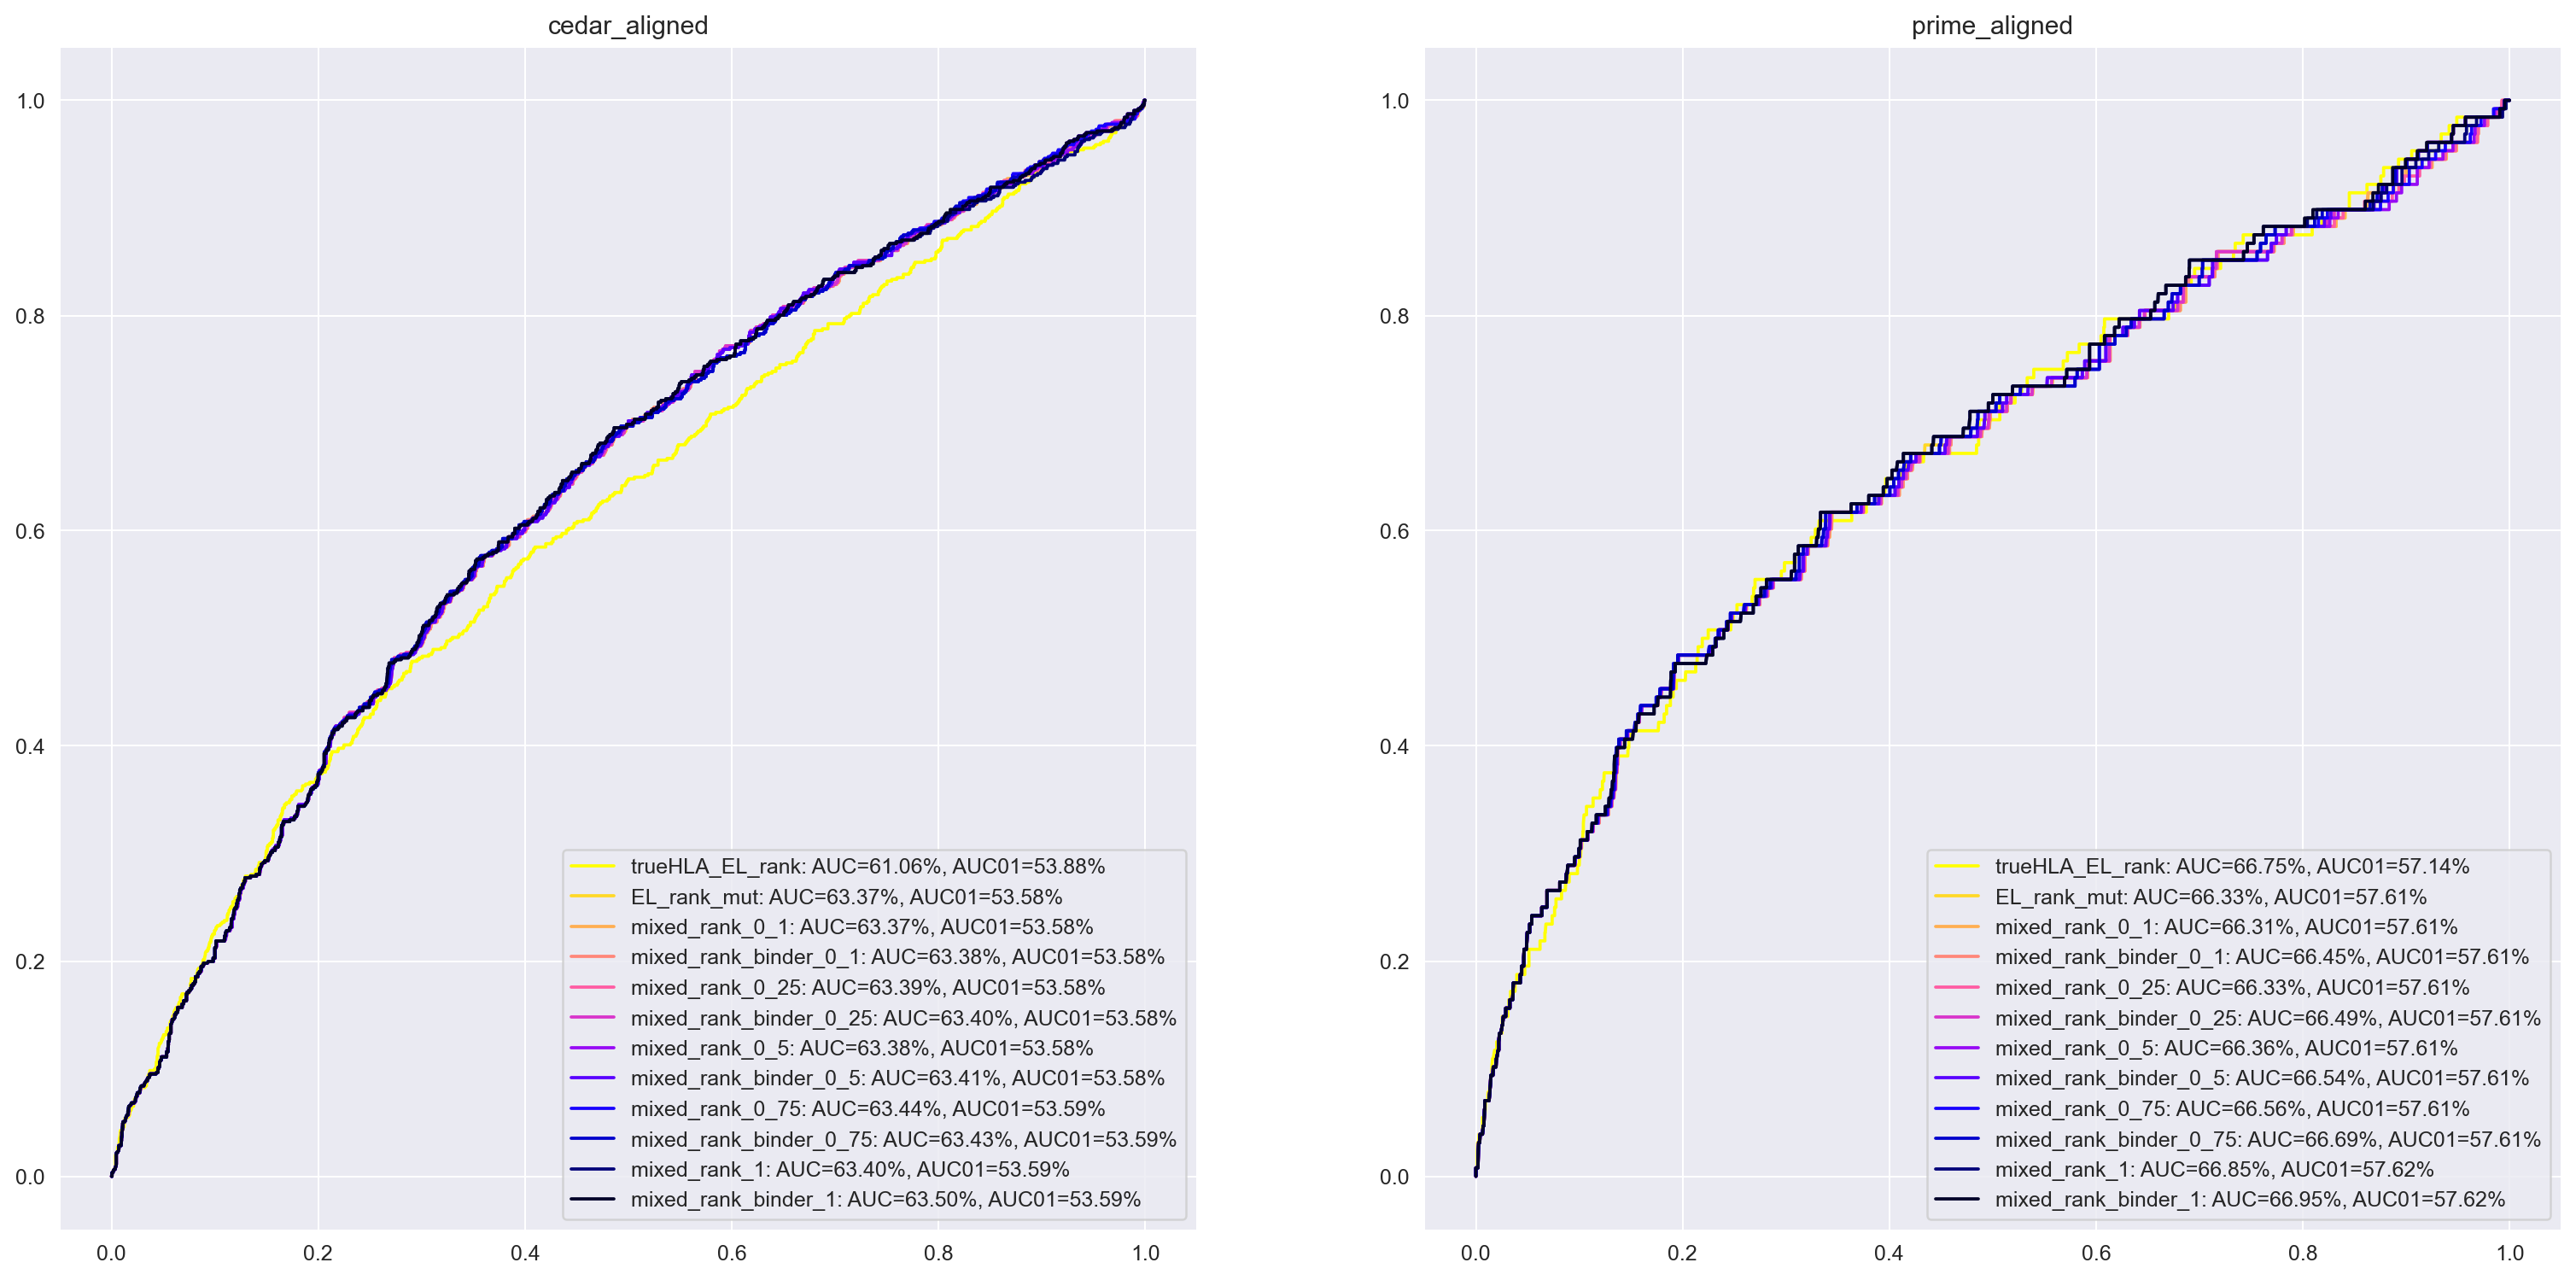

In [25]:
from sklearn.metrics import roc_curve ,roc_auc_score
f,a = plt.subplots(1,2, figsize=(21,10))
rankcols = ['trueHLA_EL_rank', 'EL_rank_mut']+[x for x in cedar_aligned.columns if x.startswith('mixed_rank_')]
sns.set_palette(get_palette('gnuplot2_r', len(rankcols)))
for rank in rankcols:
    labels = cedar_aligned['agg_label'].values
    scores = cedar_aligned[rank].values
    fpr, tpr, _ = roc_curve(labels, 1-scores)
    auc, auc01 = roc_auc_score(labels, 1-scores), roc_auc_score(labels, 1-scores, max_fpr=0.1)
    sns.lineplot(x=fpr, y=tpr, label=f'{rank}: AUC={auc:.2%}, AUC01={auc01:.2%}', estimator=None, ax=a[0])
    a[0].set_title('cedar_aligned')
    labels = prime_aligned['agg_label'].values
    scores = prime_aligned[rank].values
    fpr, tpr, _ = roc_curve(labels, 1-scores)
    auc, auc01 = roc_auc_score(labels, 1-scores), roc_auc_score(labels, 1-scores, max_fpr=0.1)
    sns.lineplot(x=fpr, y=tpr, label=f'{rank}: AUC={auc:.2%}, AUC01={auc01:.2%}', estimator=None, ax=a[1])
    a[1].set_title('prime_aligned')

In [23]:
rankcols = ['trueHLA_EL_rank', 'EL_rank_mut']+[x for x in cedar_aligned.columns if x.startswith('mixed_rank_')]
rankcols

['trueHLA_EL_rank',
 'EL_rank_mut',
 'mixed_rank_0_1',
 'mixed_rank_binder_0_1',
 'mixed_rank_0_25',
 'mixed_rank_binder_0_25',
 'mixed_rank_0_5',
 'mixed_rank_binder_0_5',
 'mixed_rank_0_75',
 'mixed_rank_binder_0_75',
 'mixed_rank_1',
 'mixed_rank_binder_1']

## Redo fig 3 and train models with the mixed inputs + the 8mer expanded core input

In [26]:
df_input_comp = pd.read_csv('../output/230415_exprscore_analysis_FINAL/df_input_comp.csv')

In [27]:
%mkdir ../output/230415_exprscore_analysis_FINAL/icore_pep_detour
%mkdir ../output/230415_exprscore_analysis_FINAL/icore_pep_detour/bootstrapping

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

ding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False,
                   'mask': False, 'invert': False,'standardize':True} 
odir = '../output/230415_exprscore_analysis_FINAL/icore_pep_detour/'
bdfs = []
for ic_name, ics_dict, mask, invert in [('Inverted Shannon', ics_shannon, False, True),
                                        ('Inverted Mask', ics_shannon, True, True),
                                        ('None', None, False, False),
                                        ('Mask', ics_shannon, True, False),
                                        ('Shannon', ics_shannon, False, False)]:
    
    for t in [0.25, .5, .75, 1]:
        for binder in [True, False]:
            if t==0.25 and binder:
                continue
            if binder:
                encoding_kwargs['seq_col'] = f'mixed_input_binder_{t}'.replace('.','_')
                encoding_kwargs['rank_col'] = f'mixed_rank_binder_{t}'.replace('.','_')
            else:
                encoding_kwargs['seq_col'] = f'mixed_input_{t}'.replace('.','_')
                encoding_kwargs['rank_col'] = f'mixed_rank_{t}'.replace('.','_')
            encoding_kwargs['mask']=mask
            encoding_kwargs['invert']=invert
            encoding_kwargs['standardize'] = True
            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                                       max_depth=8, ccp_alpha=9.945e-6)
            # Training model and getting feature importances
            print('Training')
            trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
            for evalset, evalname in zip([cedar_aligned, prime_aligned],['CEDAR','PRIME']):
                _, kcv_preds = evaluate_trained_models_sklearn(evalset,
                                                            trained_models, ics_dict,
                                                            cedar_aligned,
                                                            encoding_kwargs, concatenated=False,
                                                            only_concat=True, n_jobs=8)
                p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
                bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
                bdf['input_type'] = encoding_kwargs['seq_col']
                bdf['weight'] = ic_name
                bdf['evalset']=evalname
                bdfs.append(bdf)
                del bdf, kcv_preds
            del trained_models
input_totaldf = pd.concat(bdfs)
del bdfs
# input_totaldf.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')


Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
concat=pd.concat([df_input_comp.rename(columns={'type':'input_type'}),input_totaldf]).query('not weight.str.contains("KL")')
concat.to_csv('../output/230415_exprscore_analysis_FINAL/bootstrapped_dfs_new_inputs.csv')
concat.groupby(['weight', 'input_type']).agg(mean_auc=('auc','mean'),
                                                    mean_auc01=('auc_01','mean'))


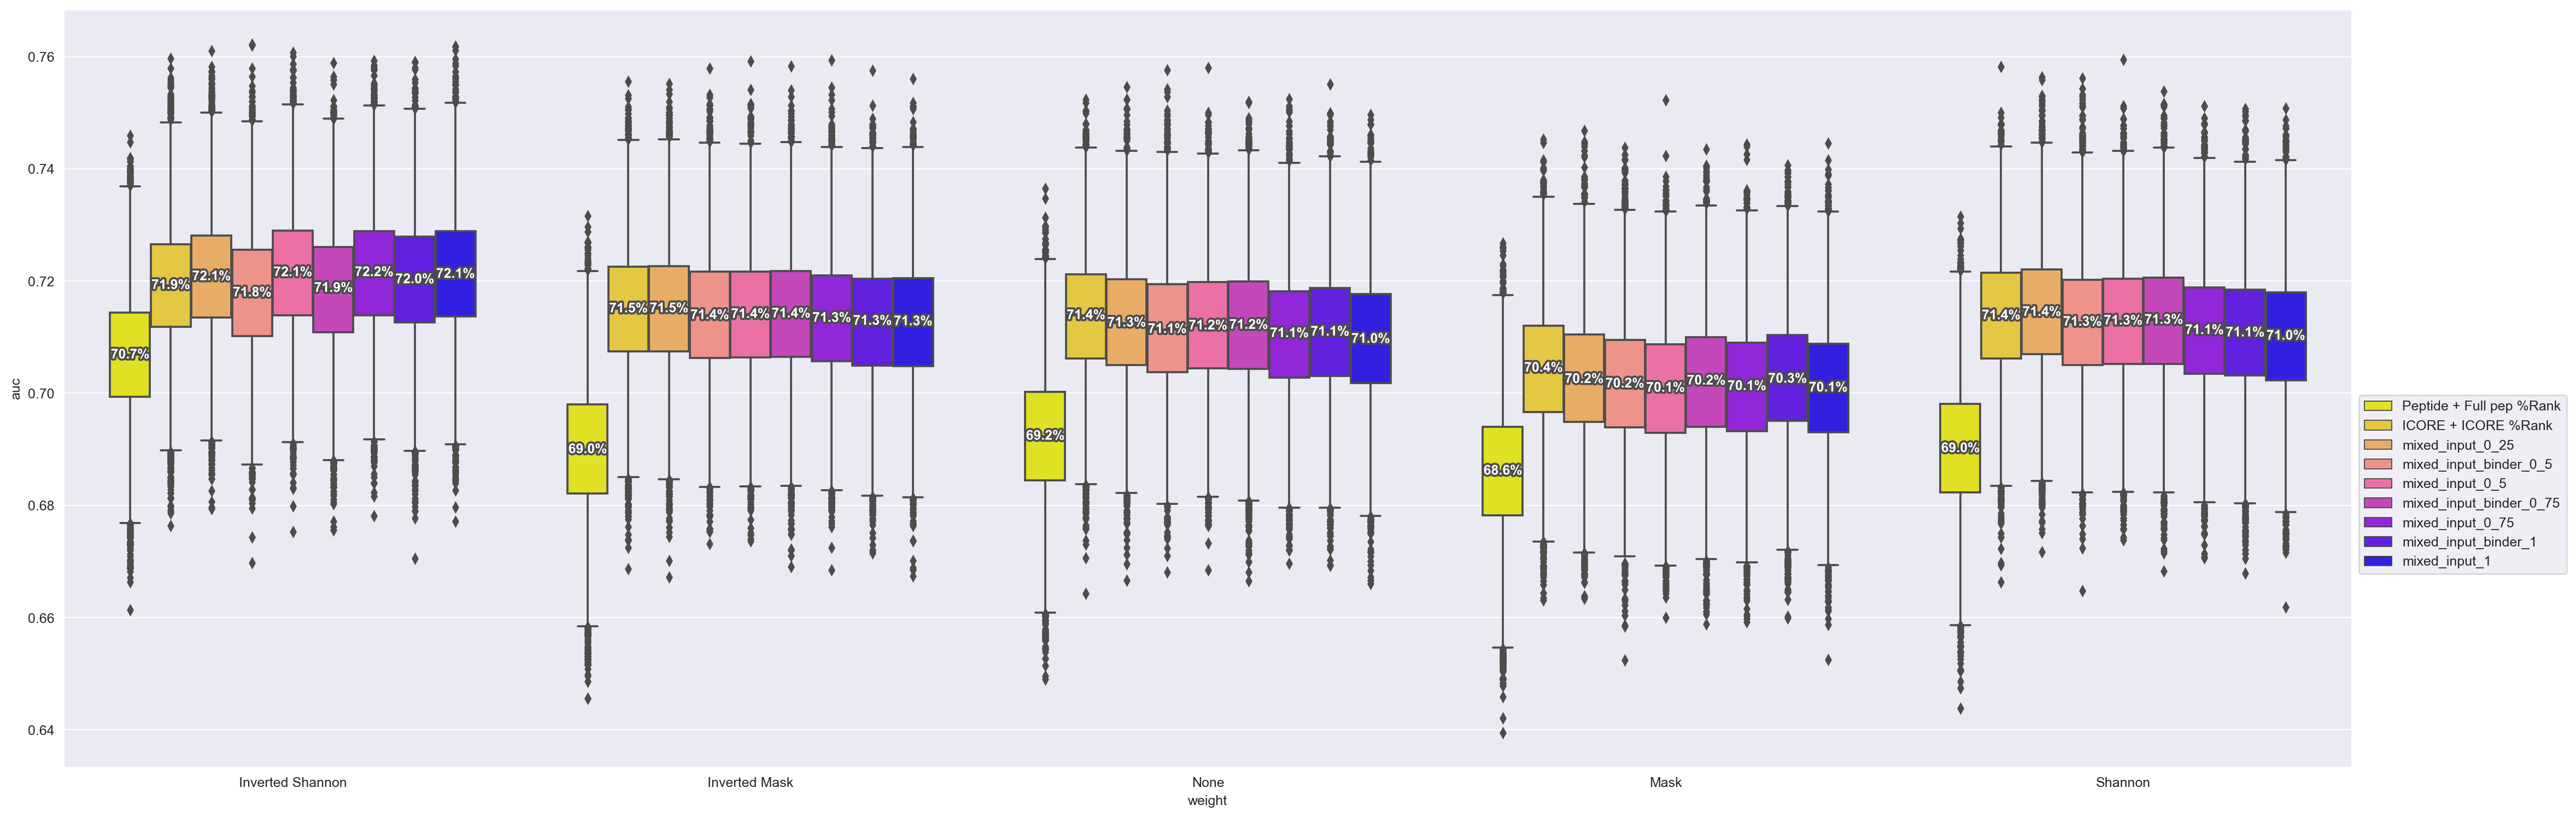

In [62]:
f,a =plt.subplots(1,1, figsize=(30,10))
sns.boxplot(concat.query('not weight.str.contains("KL")'), 
            order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon'],
            x='weight', hue='input_type', y='auc', ax=a)
a.legend(bbox_to_anchor=(1, .5))
add_median_labels(a)

In [71]:
for f in list(filter(lambda x: 'mix' in x.lower() and 'input' in x,  cedar_aligned.columns)):
    cedar_aligned[f'len_{f}'] = cedar_aligned[f].apply(len)
    print('#'*30,'\n'*3,f)
    display(cedar_aligned.groupby([f'len_{f}']).agg(count=('Peptide','count')))

############################## 


 mixed_input_0_1


,count
len_mixed_input_0_1,
8,115
9,2121
10,547
11,249
12,1


############################## 


 mixed_input_binder_0_1


,count
len_mixed_input_binder_0_1,
8,74
9,2018
10,610
11,330
12,1


############################## 


 mixed_input_0_25


,count
len_mixed_input_0_25,
8,98
9,2084
10,575
11,275
12,1


############################## 


 mixed_input_binder_0_25


,count
len_mixed_input_binder_0_25,
8,67
9,1995
10,628
11,342
12,1


############################## 


 mixed_input_0_5


,count
len_mixed_input_0_5,
8,74
9,2033
10,614
11,311
12,1


############################## 


 mixed_input_binder_0_5


,count
len_mixed_input_binder_0_5,
8,57
9,1958
10,655
11,362
12,1


############################## 


 mixed_input_0_75


,count
len_mixed_input_0_75,
8,63
9,1959
10,646
11,364
12,1


############################## 


 mixed_input_binder_0_75


,count
len_mixed_input_binder_0_75,
8,51
9,1911
10,675
11,395
12,1


############################## 


 mixed_input_1


,count
len_mixed_input_1,
8,43
9,1900
10,684
11,405
12,1


############################## 


 mixed_input_binder_1


,count
len_mixed_input_binder_1,
8,36
9,1873
10,699
11,424
12,1


TypeError: object of type 'int' has no len()

In [73]:
cedar_aligned.groupby([f'len_icore_mut']).agg(count=('Peptide','count'))

,count
len_icore_mut,
8,125
9,2146
10,525
11,236
12,1


## Do Expand 8mer stuff

In [92]:
def get_expanded_input(row):
    input_col = row['core_mut'] if row['len_icore_mut']==8 else row['icore_mut']
    return input_col
cedar_aligned['expanded_input'] = cedar_aligned.apply(get_expanded_input,axis=1)
cedar_aligned.query('expanded_input.str.contains("-")')

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,...,len_mixed_input_binder_0_1,len_mixed_input_0_25,len_mixed_input_binder_0_25,len_mixed_input_0_5,len_mixed_input_binder_0_5,len_mixed_input_0_75,len_mixed_input_binder_0_75,len_mixed_input_1,len_mixed_input_binder_1,expanded_input
39,39,39,HLA-A0201,0,9,AIYHTLNLFNI,AIYHTLNLCNI,AIYHTLNL,AIY-HTLNL,11,...,11,11,11,11,11,11,11,11,11,AIY-HTLNL
40,40,40,HLA-B0702,0,7,AKNCGIAIPV,AKNRGIAIPV,AKNCGIAI,-AKNCGIAI,10,...,10,8,10,10,10,10,10,10,10,-AKNCGIAI
105,105,105,HLA-B1501,0,5,ALSIGTSYRY,ALSIGTPYRY,ALSIGTSY,ALS-IGTSY,10,...,8,10,10,10,10,10,10,10,10,ALS-IGTSY
133,133,133,HLA-A0201,0,9,AMYLNYFRGL,AMYLNYCRGL,YLNYFRGL,YLN-YFRGL,10,...,10,10,10,10,10,10,10,10,10,YLN-YFRGL
158,158,158,HLA-B0702,0,4,APTWRALAR,APTWRALAG,APTWRALA,APT-WRALA,9,...,9,9,9,9,9,9,9,9,9,APT-WRALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,2838,2838,HLA-C1403,0,4,WYTHNLIFVF,WYTHNLFFVF,WYTHNLIF,WYT-HNLIF,10,...,8,8,8,8,8,8,8,8,8,WYT-HNLIF
2869,2869,2869,HLA-A0201,1,4,YKLVVVGAV,YKLVVVGAG,KLVVVGAV,KLV-VVGAV,9,...,9,8,9,8,9,8,9,8,9,KLV-VVGAV
2933,2933,2933,HLA-A1101,1,6,YMKSLEFENK,YMKSSEFENK,KSLEFENK,KSLE-FENK,10,...,10,10,10,10,10,10,10,10,10,KSLE-FENK
3013,3013,3013,HLA-A0201,0,3,YVMASVFVCPL,YVMASVFVCLL,YVMASVFV,YVMASVF-V,11,...,11,11,11,11,11,11,11,11,11,YVMASVF-V


In [96]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 
               'rank_col':'EL_rank_mut', 'seq_col':'expanded_input',
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False,
                   'mask': False, 'invert': False,'standardize':True} 
odir = '../output/230415_exprscore_analysis_FINAL/icore_pep_detour/'
bdfs = []
for ic_name, ics_dict, mask, invert in [('Inverted Shannon', ics_shannon, False, True),
                                        ('Inverted Mask', ics_shannon, True, True),
                                        ('None', None, False, False),
                                        ('Mask', ics_shannon, True, False),
                                        ('Shannon', ics_shannon, False, False)]:
    encoding_kwargs['mask']=mask
    encoding_kwargs['invert']=invert
    encoding_kwargs['standardize'] = True
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    trained_models, _, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                    ics_dict=ics_dict,
                                                    encoding_kwargs=encoding_kwargs,
                                                    n_jobs=8)
    
    _, kcv_preds = evaluate_trained_models_sklearn(cedar_aligned,
                                                trained_models, ics_dict,
                                                cedar_aligned,
                                                encoding_kwargs, concatenated=False,
                                                only_concat=True, n_jobs=8)
    p_col = 'pred' if 'pred' in kcv_preds.columns else 'mean_pred'
    bdf = bootstrap_eval(kcv_preds[p_col], kcv_preds['agg_label'], n_rounds=10000, n_jobs=8, add_roc=False)
    bdf['input_type'] = encoding_kwargs['seq_col']
    bdf['weight'] = ic_name
    
    bdfs.append(bdf)

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [99]:
concat = concat.append(pd.concat(bdfs))

In [103]:
prime_aligned['expanded_input'] = prime_aligned.apply(get_expanded_input, axis=1)
prime_aligned.query('expanded_input.str.contains("-")')

,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
4,4,4,HLA-B0702,0,2,AAAPAVGPPL,AAATAVGPPL,APAVGPPL,APA-VGPPL,10,...,True,APAVGPPL,0.0897,True,APAVGPPL,0.0897,True,APAVGPPL,0.0897,APA-VGPPL
5,5,5,HLA-B0702,0,3,AAAPLRGRAL,AAAPLRVRAL,APLRGRAL,APL-RGRAL,10,...,True,APLRGRAL,0.0520,True,APLRGRAL,0.0520,True,APLRGRAL,0.0520,APL-RGRAL
6,6,6,HLA-B0702,0,8,AAAPPLSPPL,AAAPHLSPPL,APPLSPPL,AP-PLSPPL,10,...,True,APPLSPPL,0.2880,True,APPLSPPL,0.2880,True,APPLSPPL,0.2880,AP-PLSPPL
14,14,14,HLA-B0702,0,3,AAPLRGRAL,AAPLRVRAL,APLRGRAL,APL-RGRAL,9,...,True,APLRGRAL,0.0520,True,APLRGRAL,0.0520,True,APLRGRAL,0.0520,APL-RGRAL
64,64,64,HLA-A0201,0,9,ALFTWTNL,AVFTWTNL,ALFTWTNL,ALFTWT-NL,8,...,False,ALFTWTNL,2.4013,False,ALFTWTNL,2.4013,False,ALFTWTNL,2.4013,ALFTWT-NL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068,3068,3068,HLA-A6802,0,1,YTFEIQGV,YTFEIQAV,YTFEIQGV,YTFEI-QGV,8,...,False,YTFEIQGV,0.5296,False,YTFEIQGV,0.5296,False,YTFEIQGV,0.5296,YTFEI-QGV
3076,3076,3076,HLA-A0201,0,5,YTHNLIFV,YTHNLFFV,YTHNLIFV,YTH-NLIFV,8,...,False,YTHNLIFV,6.7132,False,YTHNLIFV,6.7132,False,YTHNLIFV,6.7132,YTH-NLIFV
3089,3089,3089,HLA-A0201,0,9,YVAAYQRL,YVAAYQQL,YVAAYQRL,YVA-AYQRL,8,...,False,YVAAYQRL,10.5006,False,YVAAYQRL,10.5006,False,YVAAYQRL,10.5006,YVA-AYQRL
3090,3090,3090,HLA-A0101,0,3,YVDVTYNFI,YVDVTYDFI,YVDVTYNF,YVD-VTYNF,9,...,False,YVDVTYNFI,1.2849,False,YVDVTYNFI,1.2849,False,YVDVTYNFI,1.2849,YVD-VTYNF


In [139]:
input_order = list(concat.input_type.unique())
weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
input_order

['Peptide + Full pep %Rank',
 'ICORE + ICORE %Rank',
 'mixed_input_0_25',
 'mixed_input_binder_0_5',
 'mixed_input_0_5',
 'mixed_input_binder_0_75',
 'mixed_input_0_75',
 'mixed_input_binder_1',
 'mixed_input_1',
 'expanded_input']

0.0
9.999999999998899e-05


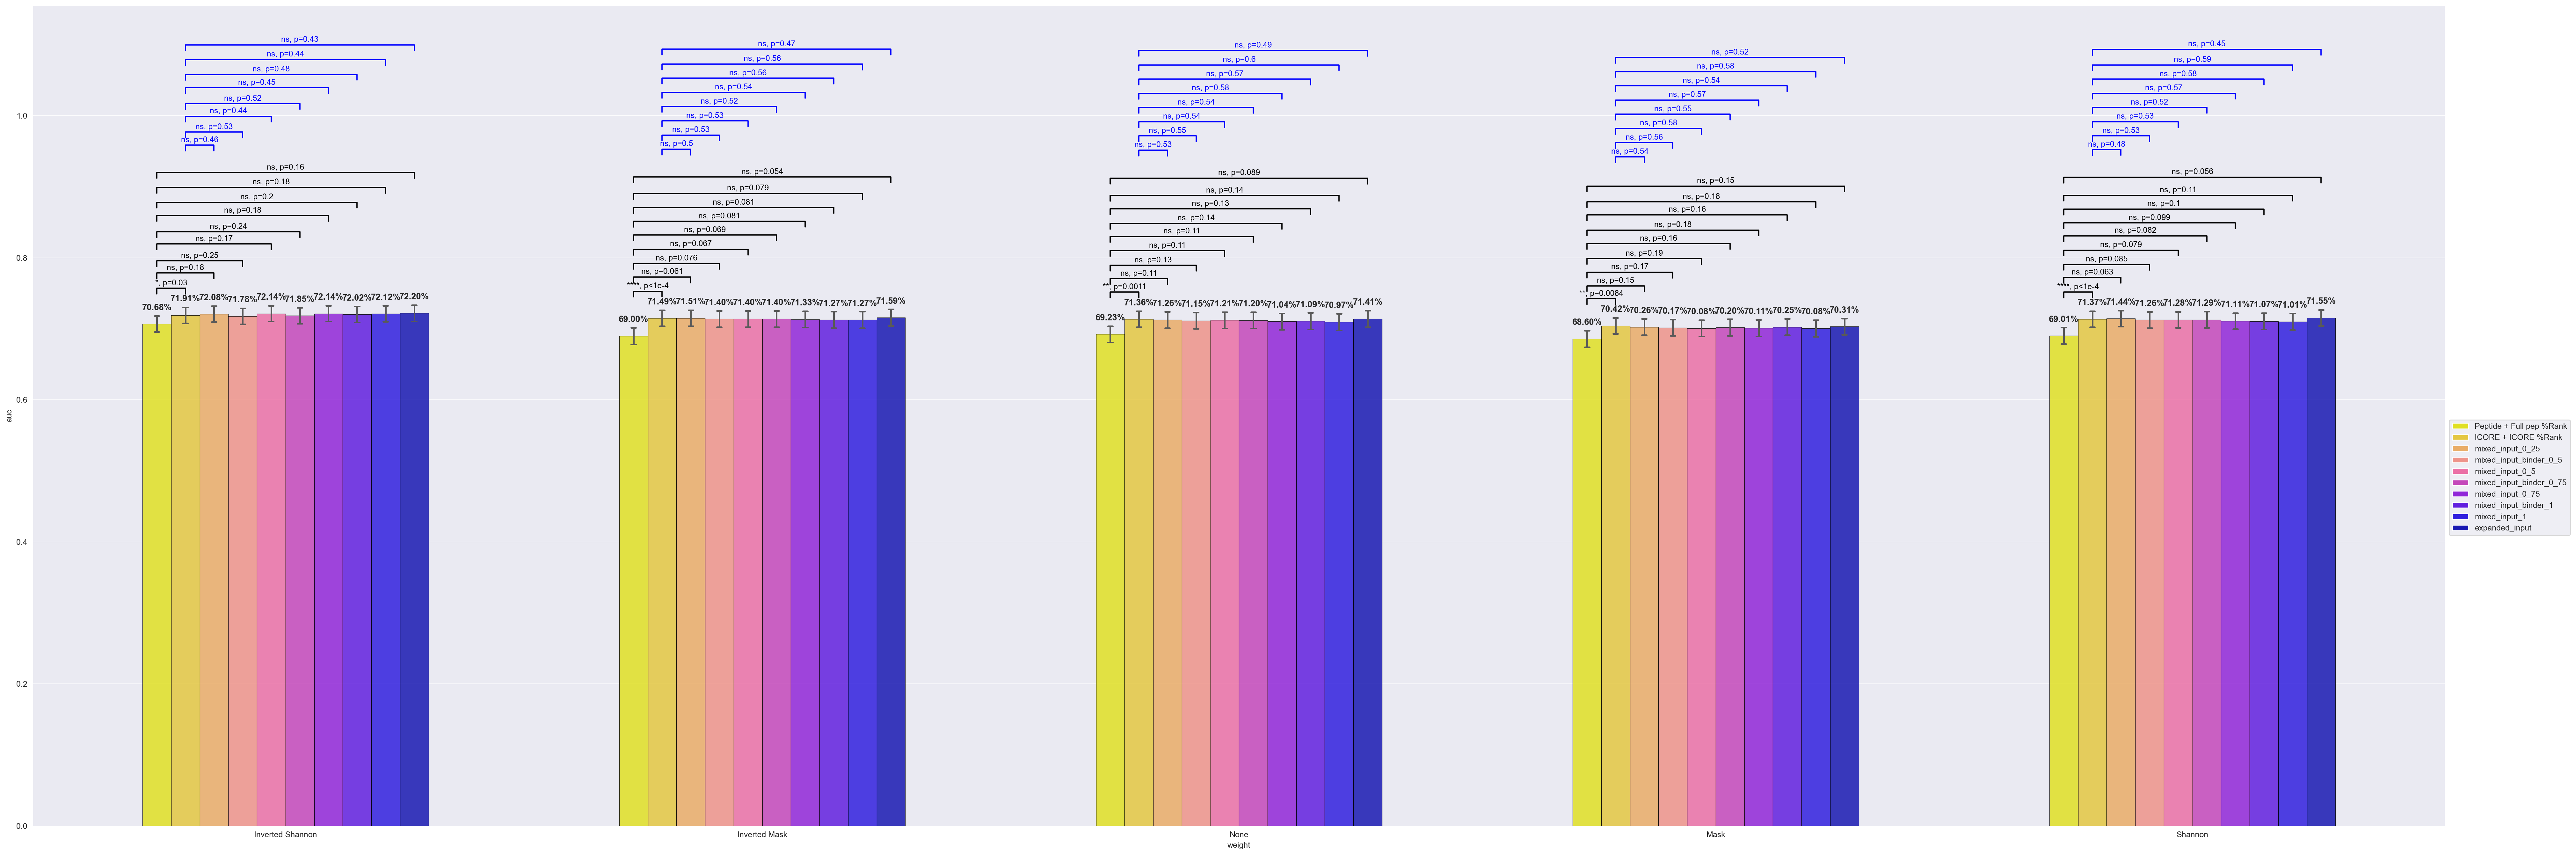

In [150]:
f,a =plt.subplots(1,1, figsize=(45,15))
df = concat.query('not weight.str.contains("KL")')
sns.barplot(df, order = weight_order, errorbar='sd', errcolor='.35',
            errwidth=2, capsize=.01, width=.6,
            x='weight', hue='input_type', y='auc', ax=a)
a.legend(bbox_to_anchor=(1, .5))
for container in a.containers:
    values = [f'{x:.2%}' for x in container.datavalues]
    a.bar_label(container, labels=values, fontsize=11, fontweight='semibold', padding=15)
plt.setp(a.patches, linewidth=0.5, edgecolor='k', alpha=0.85)
dx = a.patches[0].get_width()
# a.set_ylim([0.5, 0.8])

for i, weight in enumerate(weight_order):
    x0 = i
    xs = [x0-4.5*dx, x0-3.5*dx, x0-2.5*dx, x0-1.5*dx, x0-.5*dx,
          x0+.5*dx, x0+1.5*dx, x0+2.5*dx, x0+3.5*dx, x0+4.5*dx]
    # First compare to base
    h, h0 = 0.03, 0.01
    x1 = xs[order.index('Peptide + Full pep %Rank')]
    aucs_base = df.query("weight==@weight and input_type=='Peptide + Full pep %Rank'").auc.values
    for i, comp in enumerate(input_order):
        if comp=='Peptide + Full pep %Rank':continue
        aucs_comp = df.query("weight==@weight and input_type==@comp").auc.values
        pval, sig = get_pval(aucs_comp, aucs_base)
        plot_pval(a, pval, sig, x1, xs[i], y=max(np.mean(aucs_base),np.mean(aucs_comp))+h, h=h0, color='k')
        h+=2*h0

    # Then compare to ICORE
    h += 2*h0
    x1 = xs[order.index('ICORE + ICORE %Rank')]
    aucs_base = df.query("weight==@weight and input_type=='ICORE + ICORE %Rank'").auc.values
    for i, comp in enumerate(input_order):
        if comp=='ICORE + ICORE %Rank' or comp=='Peptide + Full pep %Rank':continue
        aucs_comp = df.query("weight==@weight and input_type==@comp").auc.values
        pval, sig = get_pval(aucs_comp, aucs_base)
        plot_pval(a, pval, sig, x1, xs[i], y=max(np.mean(aucs_base),np.mean(aucs_comp))+h, h=h0, color='b')
        h+=2*h0
f.tight_layout()

In [152]:
cedar_aligned_expr['expanded_input'] = cedar_aligned_expr.apply(get_expanded_input, axis=1)
prime_aligned_expr['expanded_input'] = prime_aligned_expr.apply(get_expanded_input, axis=1)
nepdb_aligned_expr['expanded_input'] = nepdb_aligned_expr.apply(get_expanded_input, axis=1)

cedar_aligned_expr.query('expanded_input.str.contains("-")')

,Unnamed: 0.1,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,...,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr_icore,impr_pep,ic_len,expanded_input
39,39,39,AIYHTLNLFNI,HLA-A0201,4.7939,0,5,3.4539,4.7939,32.330000,...,8,>seq_40,5.8573,AIYHTLNLCNI,2.049193e-13,0.000000,False,False,353,AIY-HTLNL
40,40,40,AKNCGIAIPV,HLA-B0702,33.2727,0,4,7.5456,16.9099,4.721020,...,8,>seq_41,52.6923,AKNRGIAIPV,0.000000e+00,32.196201,False,False,17862,-AKNCGIAI
103,103,103,ALSIGTSYRY,HLA-B1501,0.3522,0,3,0.4894,0.8871,0.001000,...,8,>seq_106,0.4303,ALSIGTPYRY,0.000000e+00,0.212368,True,False,3004,ALS-IGTSY
131,131,131,AMYLNYFRGL,HLA-A0201,5.4228,0,7,9.5592,9.7252,87.822400,...,8,>seq_134,6.1562,AMYLNYCRGL,7.619771e-03,2.399031,False,False,353,YLN-YFRGL
155,155,155,APTWRALAR,HLA-B0702,2.3117,0,9,1.4481,2.3117,6.321210,...,8,>seq_159,2.6840,APTWRALAG,0.000000e+00,0.000000,False,False,17862,APT-WRALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2794,2794,2794,WYTHNLIFVF,HLA-C1403,0.5629,0,1,0.6155,0.6155,2.281050,...,8,>seq_2839,2.8869,WYTHNLFFVF,0.000000e+00,0.048105,False,False,27298,WYT-HNLIF
2824,2824,2824,YKLVVVGAV,HLA-A0201,7.6549,1,6,46.6000,46.6000,83.541700,...,8,>seq_2870,27.7097,YKLVVVGAG,5.895247e-05,6.397443,False,False,353,KLV-VVGAV
2888,2888,2888,YMKSLEFENK,HLA-A1101,3.9345,1,2,2.7059,4.0461,8.350720,...,8,>seq_2934,3.9487,YMKSSEFENK,0.000000e+00,0.108522,False,False,79,KSLE-FENK
2968,2968,2968,YVMASVFVCPL,HLA-A0201,3.0785,0,0,0.5738,3.0785,19.341100,...,8,>seq_3014,3.6690,YVMASVFVCLL,0.000000e+00,0.000000,False,False,353,YVMASVF-V


In [156]:
cedar_aligned_expr.to_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_aligned_expr.to_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_aligned_expr.to_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

In [148]:
a=df.query("weight=='None' and input_type=='Peptide + Full pep %Rank'").auc.values
b=df.query("weight=='None' and input_type=='expanded_input'").auc.values
get_pval(b,a)

(0.08889999999999998, 'ns')

In [157]:
'icore_dissimilarity_score-icore_blsm_mut_score'.replace('icore','')

'_dissimilarity_score-_blsm_mut_score'